In [20]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, confusion_matrix,
                           classification_report, RocCurveDisplay)

# Load and prepare data
df = pd.read_csv('Default_Fin.csv')
df = df.drop('Index', axis=1, errors='ignore')
df.rename(columns={
    'Employed': 'Employment_Status',
    'Bank Balance': 'Bank_Balance',
    'Annual Salary': 'Annual_Salary'
}, inplace=True)

# Feature engineering
df['Debt_to_Income'] = df['Bank_Balance'] / (df['Annual_Salary'] + 1)
features = ['Employment_Status', 'Bank_Balance', 'Annual_Salary', 'Debt_to_Income']
X = df[features]
y = df['Defaulted?']

# Check class distribution
print("Class Distribution:\n", y.value_counts())
print("Default Rate: {:.2f}%".format(y.mean() * 100))


# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numerical features
scaler = StandardScaler()
num_cols = ['Bank_Balance', 'Annual_Salary', 'Debt_to_Income']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Calculate class imbalance ratio
imbalance_ratio = len(y[y == 0]) / len(y[y == 1])

Class Distribution:
 Defaulted?
0    9667
1     333
Name: count, dtype: int64
Default Rate: 3.33%


In [15]:
logreg = LogisticRegression(
    class_weight='balanced',
    random_state=42,
    max_iter=1000
)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
y_proba_logreg = logreg.predict_proba(X_test)[:, 1]

print("\n=== Logistic Regression ===")
print("Accuracy: {:.3f}".format(accuracy_score(y_test, y_pred_logreg)))
print("Recall: {:.3f}".format(recall_score(y_test, y_pred_logreg)))  # Most important metric
print("ROC AUC: {:.3f}".format(roc_auc_score(y_test, y_proba_logreg)))
print(classification_report(y_test, y_pred_logreg))


=== Logistic Regression ===
Accuracy: 0.854
Recall: 0.881
ROC AUC: 0.949
              precision    recall  f1-score   support

           0       1.00      0.85      0.92      1933
           1       0.17      0.88      0.29        67

    accuracy                           0.85      2000
   macro avg       0.58      0.87      0.60      2000
weighted avg       0.97      0.85      0.90      2000




=== Random Forest ===
Accuracy: 0.866
Recall: 0.836
ROC AUC: 0.935
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      1933
           1       0.18      0.84      0.29        67

    accuracy                           0.87      2000
   macro avg       0.59      0.85      0.61      2000
weighted avg       0.97      0.87      0.90      2000



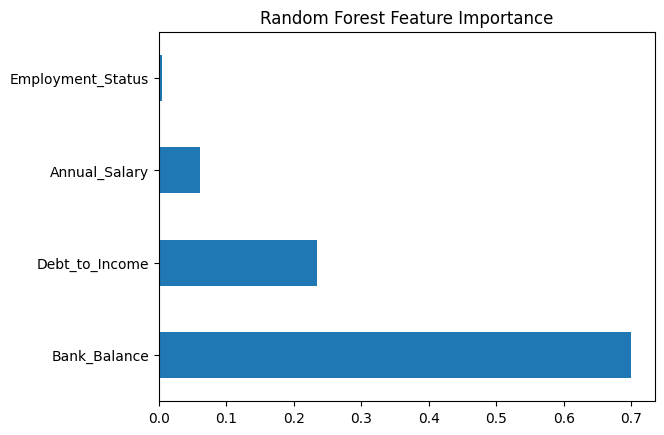

In [16]:
rf = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_estimators=150,
    max_depth=5
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("\n=== Random Forest ===")
print("Accuracy: {:.3f}".format(accuracy_score(y_test, y_pred_rf)))
print("Recall: {:.3f}".format(recall_score(y_test, y_pred_rf)))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_test, y_proba_rf)))
print(classification_report(y_test, y_pred_rf))

# Feature importance
feat_importances = pd.Series(rf.feature_importances_, index=features)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Random Forest Feature Importance')
plt.show()


=== XGBoost ===
Accuracy: 0.845
Recall: 0.896
ROC AUC: 0.939
              precision    recall  f1-score   support

           0       1.00      0.84      0.91      1933
           1       0.17      0.90      0.28        67

    accuracy                           0.84      2000
   macro avg       0.58      0.87      0.60      2000
weighted avg       0.97      0.84      0.89      2000



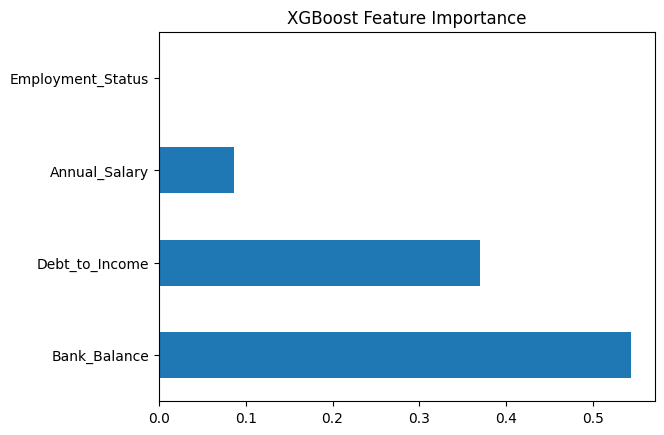

In [17]:
xgb = XGBClassifier(
    scale_pos_weight=imbalance_ratio,
    eval_metric='aucpr',
    early_stopping_rounds=10,
    random_state=42,
    n_estimators=200,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8
)

# Train with validation set
X_train_xgb, X_val, y_train_xgb, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

xgb.fit(
    X_train_xgb, y_train_xgb,
    eval_set=[(X_val, y_val)],
    verbose=False
)

y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

print("\n=== XGBoost ===")
print("Accuracy: {:.3f}".format(accuracy_score(y_test, y_pred_xgb)))
print("Recall: {:.3f}".format(recall_score(y_test, y_pred_xgb)))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_test, y_proba_xgb)))
print(classification_report(y_test, y_pred_xgb))

# Feature importance
xgb_importances = pd.Series(xgb.feature_importances_, index=features)
xgb_importances.nlargest(10).plot(kind='barh')
plt.title('XGBoost Feature Importance')
plt.show()


=== Model Comparison ===
                     Accuracy  Precision  Recall     F1  ROC AUC
Model                                                           
Logistic Regression     0.854      0.172   0.881  0.288    0.949
Random Forest           0.866      0.179   0.836  0.295    0.935
XGBoost                 0.845      0.165   0.896  0.279    0.939


<Figure size 800x600 with 0 Axes>

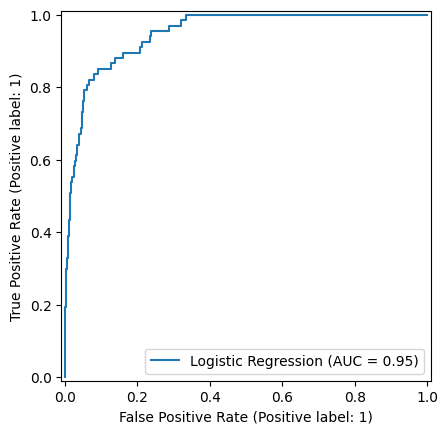

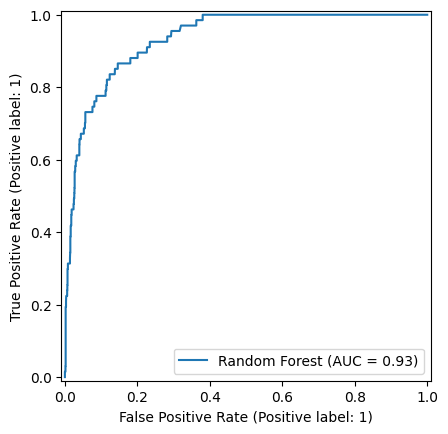

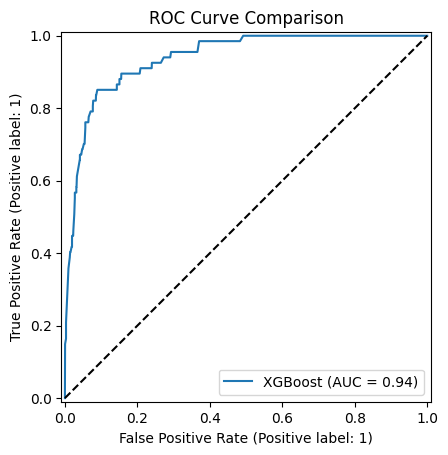

In [18]:
# Compare all models
results = []
for name, model in [('Logistic Regression', logreg),
                   ('Random Forest', rf),
                   ('XGBoost', xgb)]:
    y_pred = model.predict(X_test)
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    })

results_df = pd.DataFrame(results).set_index('Model')
print("\n=== Model Comparison ===")
print(results_df.round(3))

# Plot ROC curves
plt.figure(figsize=(8, 6))
for name, model in [('Logistic Regression', logreg),
                   ('Random Forest', rf),
                   ('XGBoost', xgb)]:
    RocCurveDisplay.from_estimator(model, X_test, y_test, name=name)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison')
plt.show()

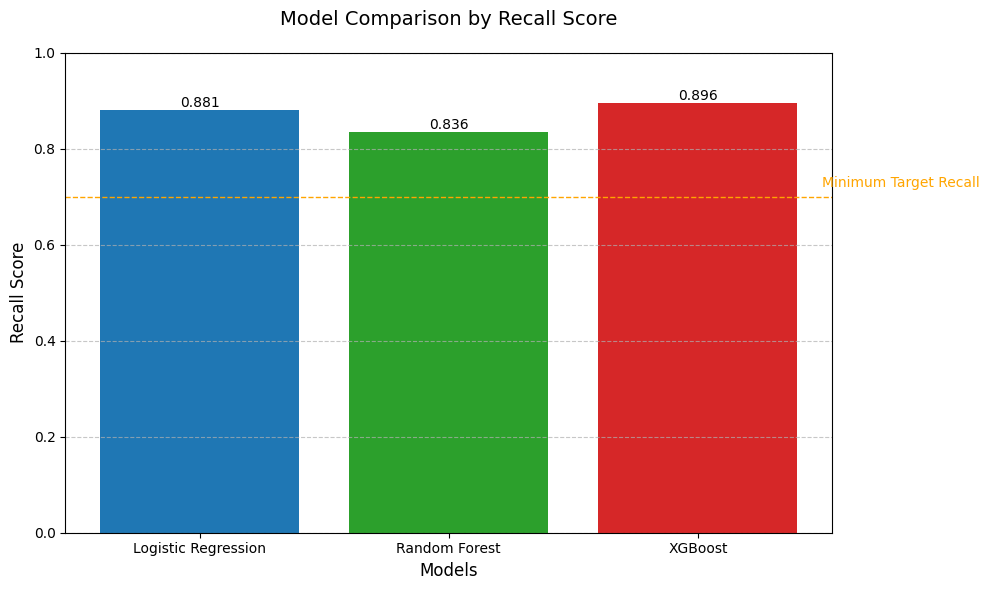

In [19]:
# Create recall comparison visualization
plt.figure(figsize=(10, 6))

# Data for plotting
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
recall_scores = [
    recall_score(y_test, y_pred_logreg),
    recall_score(y_test, y_pred_rf),
    recall_score(y_test, y_pred_xgb)
]

# Create bar plot
bars = plt.bar(models, recall_scores, color=['#1f77b4', '#2ca02c', '#d62728'])

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

# Customize plot
plt.title('Model Comparison by Recall Score', pad=20, fontsize=14)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Recall Score', fontsize=12)
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add horizontal line at "good" recall threshold
plt.axhline(y=0.7, color='orange', linestyle='--', linewidth=1)
plt.text(2.5, 0.72, 'Minimum Target Recall', color='orange')

plt.tight_layout()
plt.show()